In [1]:
#https://www.kaggle.com/pgladkov/fraud-detection-using-autoencoder
'''
The idea to apply it to anomaly detection is very straightforward:

train an auto-encoder on X_train with good regularization

evaluate it on the validation set X_val and visualise the reconstructed error plot

choose a threshold which determines whether a value is an outlier (anomalies) or not

http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
'''
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
try:
    data = pd.read_csv("creditcard.csv")
except Exception as e:
    data = pd.read_csv("creditcard.csv")
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,Class
0,2.869500,0.261528,1.082740,1.368581,0.726066,2.232758,-1.049083,-0.172560,-0.149720,-0.499941,0.907230,0.147553,0.720398,0.098597,-0.937092,0.691312,0.163763,1
1,-1.104155,-1.273079,-1.132283,0.167332,-0.260986,0.139257,0.101525,-0.166491,-0.102144,0.540399,0.395563,-0.331008,-0.073304,0.374275,-1.211132,-0.370749,0.125104,0
2,-0.326550,-2.326835,-0.178921,0.400176,-0.545348,-0.591515,-0.269137,-0.337215,-0.543760,0.477881,0.082324,0.707100,0.581888,-0.539279,-0.789139,-0.561121,0.195145,0
3,1.732949,-0.640775,0.238903,0.265234,-1.049351,-0.066576,-0.201804,-0.859689,-0.258899,0.670371,0.027415,1.114816,-0.705536,0.580306,-0.734023,0.276237,0.148903,0
4,0.664902,-0.607301,-0.552523,0.370550,0.319864,-0.080966,-0.127116,-1.112993,0.109274,1.001245,1.032436,-0.057926,-1.242043,0.540745,-0.239575,-0.032246,0.167661,0


In [4]:
x  = data.values[:,:-1]     
y  = data.values[:,-1]

Text(0,0.5,'Frequency')

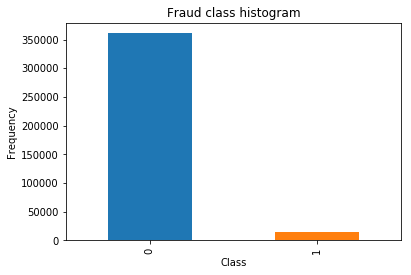

In [5]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

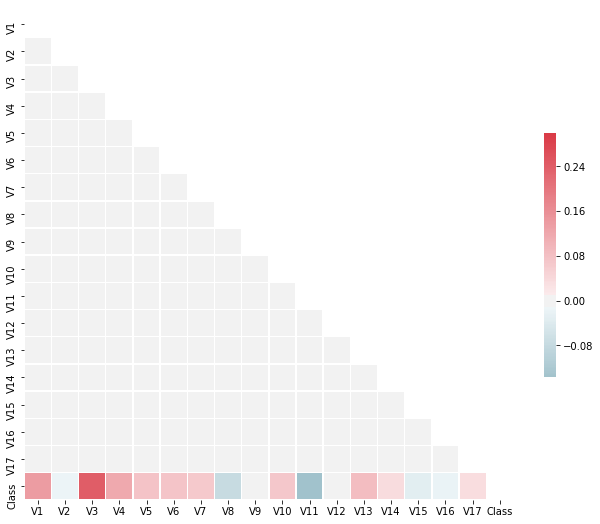

In [6]:
import seaborn as sns
# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

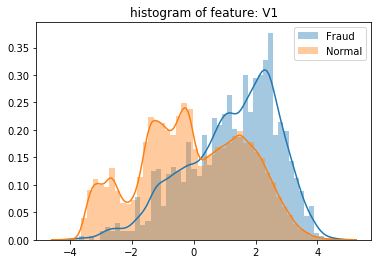

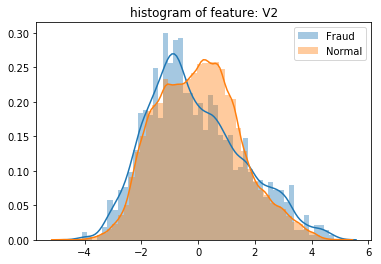

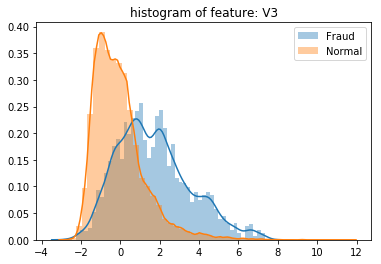

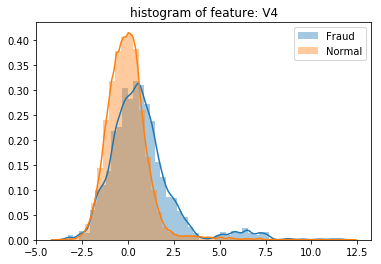

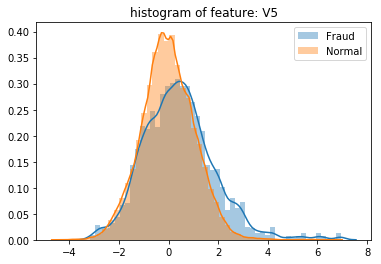

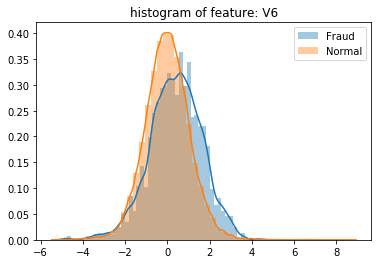

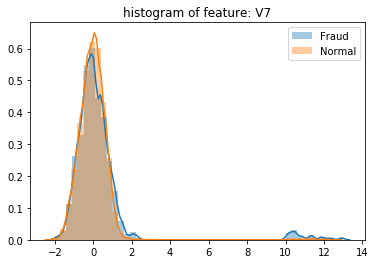

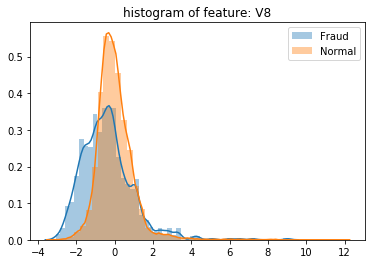

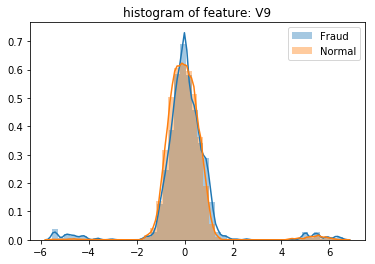

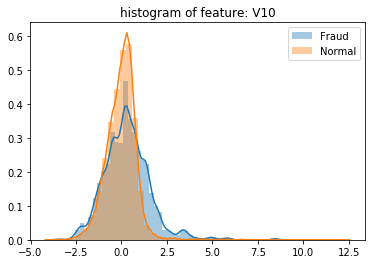

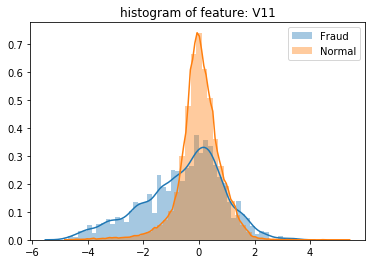

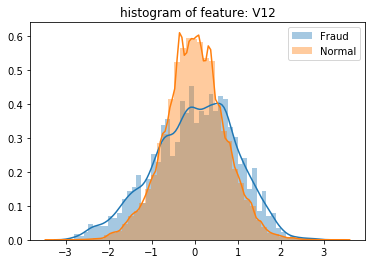

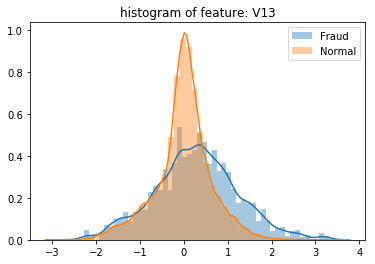

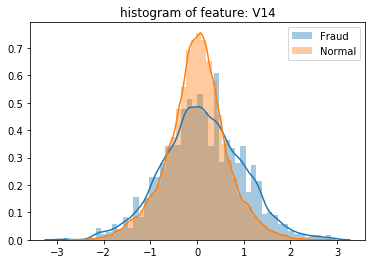

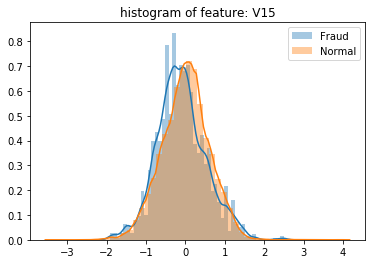

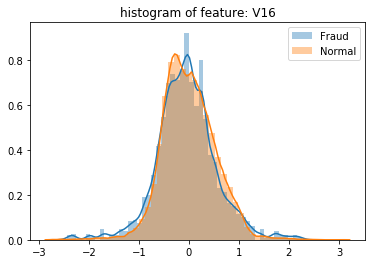

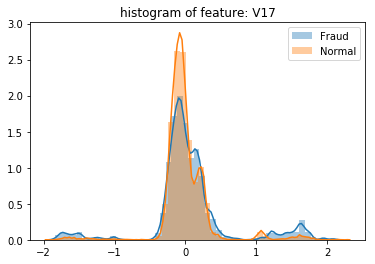

E:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
E:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


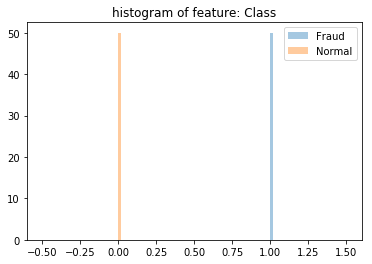

In [7]:
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(12,28*5))
# gs = gridspec.GridSpec(28, 1)
for feature in data.columns[ 0:32]:
    ax = plt.subplot()
    sns.distplot(data[feature][data.Class == 1], bins=50, label='Fraud')
    sns.distplot(data[feature][data.Class == 0], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()


Feature ranking:
1. feature 2 (0.091165)
2. feature 10 (0.076415)
3. feature 12 (0.064293)
4. feature 0 (0.063270)
5. feature 16 (0.062424)
6. feature 7 (0.060033)
7. feature 9 (0.057411)
8. feature 1 (0.056288)
9. feature 3 (0.055199)
10. feature 11 (0.053541)
11. feature 13 (0.053345)
12. feature 4 (0.053158)
13. feature 14 (0.051937)
14. feature 6 (0.050914)
15. feature 5 (0.050804)
16. feature 8 (0.050156)
17. feature 15 (0.049646)


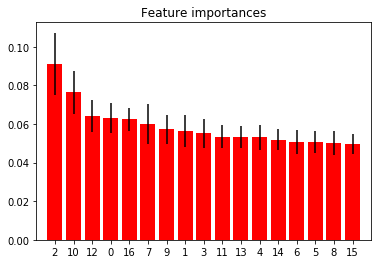

In [9]:
from sklearn.preprocessing import StandardScaler
data = data.drop(['Time'], axis=1)
y_trained=data['Class']
X_trained = data.drop(['Class'], axis=1)

#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#This examples shows the use of forests of trees to evaluate the importance of features on an artificial 
#classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X_trained, y_trained)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_trained.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_trained.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_trained.shape[1]), indices)
plt.xlim([-1, X_trained.shape[1]])
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
from sklearn.preprocessing import RobustScaler
#2 data['normAmount'] = RobustScaler().fit_transform(data['Amount'].reshape(-1, 1))
#1 data['normAmount'] = QuantileTransformer(output_distribution='uniform').fit_transform(data['Amount'].values.reshape(-1, 1))
# hour = data['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
# data['hour'] = StandardScaler().fit_transform(hour.reshape(-1, 1))
#data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))


data = data.drop(['Time','Amount'],axis=1)
data.head()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [12]:
def lrelu(x, alpha=0.3):
    # leaky relu function
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)
def prelu(x, scope=None):
    #parametric ReLU activation
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        alpha = tf.get_variable("prelu", shape=x.get_shape()[-1],
                                 dtype=x.dtype, initializer=tf.constant_initializer(0.1))
        return tf.maximum(0.0, x) + alpha * tf.minimum(0.0, x)

    
keep_prob = tf.placeholder(tf.float32)     
#Autoencoder
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.n_hidden_4 = n_hidden_4
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.placeholder("float", [None, self.n_input])

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        '''
        GradientDescentOptimizer implements the most basic version of Gradient Descent while RMSPropOptimizer
        implements an adaptive version of Stochastic Gradient Descent called RMS Prop "Root Mean Squared Propagation.
        Basic gradient descent is the slowest of any of the neural network optimizers, you will want to run it for a 
        much longer number of epochs if you want to achieve results similar to RMSProp. In fact just about anyone of the
        other methods:
        tf.train.AdagradOptimizer, tf.train.AdagradDAOptimizer, tf.train.MomentumOptimizer, tf.train.AdamOptimizer, 
        tf.train.FtrlOptimizer,.
        '''
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)
        #self.optimizer = tf.train.MomentumOptimizer(self.learning_rate).minimize(self.cost)
        #self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        weights = {
            'encoder_h1': tf.Variable(tf.random_normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2])),
            'encoder_h3': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_3])),
            'encoder_h4': tf.Variable(tf.random_normal([self.n_hidden_3, self.n_hidden_4])),
            'decoder_h1': tf.Variable(tf.random_normal([self.n_hidden_4, self.n_hidden_3])),
            'decoder_h2': tf.Variable(tf.random_normal([self.n_hidden_3, self.n_hidden_2])),
            'decoder_h3': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h4': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'encoder_b3': tf.Variable(tf.random_normal([self.n_hidden_3])),
            'encoder_b4': tf.Variable(tf.random_normal([self.n_hidden_4])),
            'decoder_b1': tf.Variable(tf.random_normal([self.n_hidden_3])),
            'decoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'decoder_b3': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'decoder_b4': tf.Variable(tf.random_normal([self.n_input])),

        }

        return weights, biases
#model = Autoencoder(n_hidden_1=20, n_hidden_2=15, n_hidden_3=10, n_hidden_4=3, n_input=X_train.shape[1], learning_rate = 0.006)    
    def encoder(self, X):
        
        #layer_1 = prelu(tf.add(tf.matmul(X, self.weights['encoder_h1']),
        layer_1 = tf.nn.elu(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = lrelu(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        layer_3 = lrelu(tf.add(tf.matmul(layer_2, self.weights['encoder_h3']),
                                       self.biases['encoder_b3']))
        layer_4 = lrelu(tf.add(tf.matmul(layer_3, self.weights['encoder_h4']),
                                       self.biases['encoder_b4']))
        return layer_4

    def decoder(self, X):
        layer_1 = tf.nn.elu(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = lrelu(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        layer_3 = lrelu(tf.add(tf.matmul(layer_2, self.weights['decoder_h3']),
                                       self.biases['decoder_b3']))
        layer_4 = lrelu(tf.add(tf.matmul(layer_3, self.weights['decoder_h4']),
                                       self.biases['decoder_b4']))
        
        return layer_4

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})
    

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})
    

In [13]:
#Train test split
from sklearn.cross_validation import train_test_split

E:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
good_data = data[data['Class'] == 0]
bad_data = data[data['Class'] == 1]
#print 'bad: {}, good: {}'.format(len(bad_data), len(good_data))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [16]:
#I would like to generate Synthetic Samples by SMOTE.
#SMOTE is a synthetic minority over-sampling technique to over sample the data. 
#I reduce the nonfraud data point to quarter to reduce the time to train the model.
from imblearn.over_sampling import SMOTE
sub_non_fraud = data.loc[data.loc[:, 'Class'] == 0, :].sample(int(len(data.loc[:, 'Class']) / 2))
data_resample = pd.concat([sub_non_fraud, data.loc[data.loc[:, 'Class'] == 1, :]])
X = data_resample.iloc[:, 1:29]
y = data_resample.loc[:, "Class"]
sm = SMOTE(kind='regular')
X_resampled, y_resampled = sm.fit_sample(X, y)
print(len(X))
print(len(y))

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [12]:
# size of X and y after SMOTE
print("Size of X", X_resampled.shape)
print("Size of y", y_resampled.shape)
print("Size of fraud", y_resampled[y_resampled == 1].shape)
print(len(X_resampled))
print(len(y_resampled))

Size of X (284806, 28)
Size of y (284806,)
Size of fraud (142403,)
284806
284806


In [13]:
from sklearn.model_selection import train_test_split
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.DataFrame(y_resampled)
#train_test_split splits arrays or matrices into random train and test subsets. 
#That means that everytime you run it without specifying random_state, you will get a different result, 
#this is expected behavior. 
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
'''
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

c = [0.01, 0.1, 1, 10]


X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

y_train, y_test = train_test_split(data, test_size = 0.2, random_state = 42)
X_train = X_train[X_train['Class']==0]

X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values'''
print(len(X_train))
#print(len(y_train))
print(len(X_resampled))
print(len(y_resampled))

227451
284806
284806


In [14]:
X_good = good_data.iloc[:, good_data.columns != 'Class']
y_good = good_data.iloc[:, good_data.columns == 'Class']

X_bad = bad_data.iloc[:, bad_data.columns != 'Class']
y_bad = bad_data.iloc[:, bad_data.columns == 'Class']

In [15]:
#Model
#Model
model = Autoencoder(n_hidden_1=20, n_hidden_2=15, n_hidden_3=10, n_hidden_4=3, n_input=X_train.shape[1], learning_rate = 0.006)


In [16]:
training_epochs = 65
batch_size = 256
display_step = 100
record_step = 1

In [18]:
#For acuracy: https://www.kaggle.com/ep1804/credit-card-fraud-decision-by-nn-wip
#Train
total_batch = int(X_train.shape[0]/batch_size)
cv=5
cost_summary = []
recall_accs = []
for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]
        
        cost = model.partial_fit(batch)

    
    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)
        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})
#if epoch % display_step == 0:
#print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))

    print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))
      

Epoch:1, cost=0.968728364
Epoch:2, cost=0.919501066
Epoch:3, cost=0.832269311
Epoch:4, cost=0.683298945
Epoch:5, cost=0.624745071
Epoch:6, cost=0.602282405
Epoch:7, cost=0.584668100
Epoch:8, cost=0.538301945
Epoch:9, cost=0.563160062
Epoch:10, cost=0.518685699
Epoch:11, cost=0.513028383
Epoch:12, cost=0.483098716
Epoch:13, cost=0.488388509
Epoch:14, cost=0.458554596
Epoch:15, cost=0.441619635
Epoch:16, cost=0.440550447
Epoch:17, cost=0.429227173
Epoch:18, cost=0.431452602
Epoch:19, cost=0.435980082
Epoch:20, cost=0.424632639
Epoch:21, cost=0.418672293
Epoch:22, cost=0.419009358
Epoch:23, cost=0.417416573
Epoch:24, cost=0.417340577
Epoch:25, cost=0.415823430
Epoch:26, cost=0.417932421
Epoch:27, cost=0.413429737
Epoch:28, cost=0.411524683
Epoch:29, cost=0.413390905
Epoch:30, cost=0.407865107
Epoch:31, cost=0.408480614
Epoch:32, cost=0.401639223
Epoch:33, cost=0.410409302
Epoch:34, cost=0.397252113
Epoch:35, cost=0.400314599
Epoch:36, cost=0.394200087
Epoch:37, cost=0.401602119
Epoch:38, 

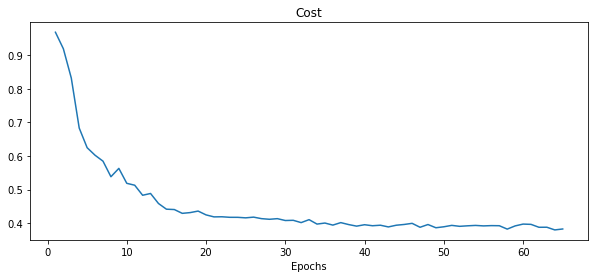

In [19]:
f, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('Cost')

plt.xlabel('Epochs')
plt.show()

In [20]:
#Test
encode_decode = None
total_batch = int(X_test.shape[0]/batch_size) + 1
for i in range(total_batch):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch = X_test[batch_start:batch_end, :]
    batch_res = model.reconstruct(batch)
    if encode_decode is None:
        encode_decode = batch_res
    else:
        encode_decode = np.vstack((encode_decode, batch_res))

In [21]:
def get_df(orig, ed, _y):
    rmse = np.mean(np.power(orig - ed, 2), axis=1)
    return pd.DataFrame({'rmse': rmse, 'target': _y})

In [22]:
df = get_df(X_test, encode_decode, y_test)
print(len(X_train))
#print(len(y_train))

227451


In [23]:
df.describe()

,rmse,target
count,56962.000000,56962.000000
mean,0.418491,0.001720
std,1.679138,0.041443
min,0.035669,0.000000
25%,0.169837,0.000000
50%,0.260099,0.000000
75%,0.426231,0.000000
max,127.286812,1.000000


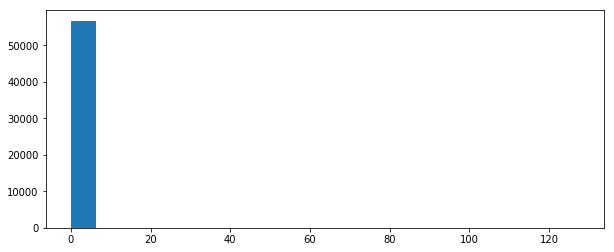

In [24]:
#Reconstruction error without fraud
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target']== 0].rmse.values, bins=20)

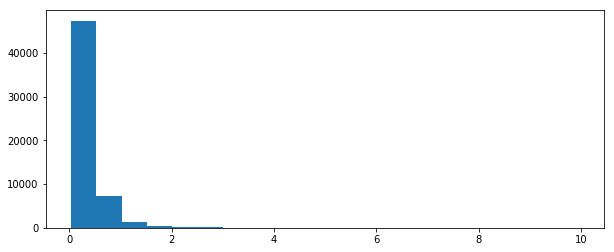

In [25]:
#Reconstruction error with fraud
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target']== 0) & (df['rmse'] < 10)].rmse.values, bins=20)

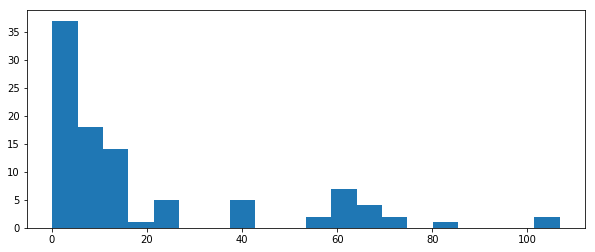

In [26]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target'] > 0].rmse.values, bins=20)

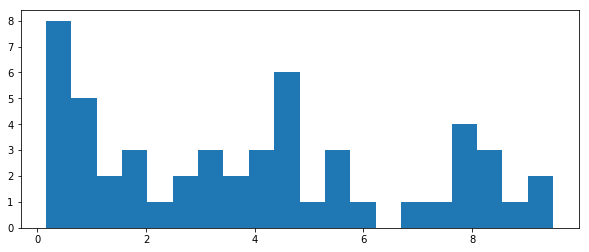

In [27]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target'] > 0) & (df['rmse'] < 10)].rmse.values, bins=20)

In [28]:
#Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score, 
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [29]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

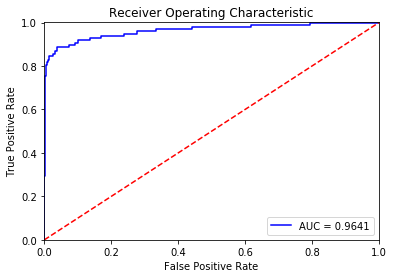

In [30]:
#ROC AUC
fpr, tpr, thresholds = roc_curve(df.target, df.rmse)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

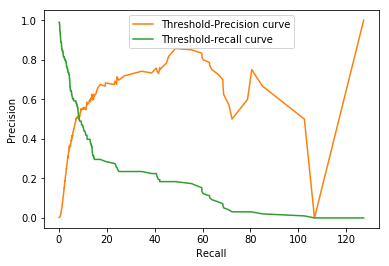

In [31]:
#Precision-Recall
precision, recall, th = precision_recall_curve(df.target, df.rmse)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.plot(th, precision[1:], 'C1', label='Threshold-Precision curve')
plt.plot(th, recall[1:], 'C2', label='Threshold-recall curve')

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [1]:
df.rmse.values

NameError: name 'df' is not defined

Recall metric in the testing dataset:  0.7346938775510204


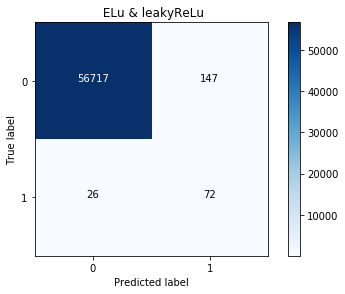

In [70]:
# Compute confusion marix
y_pred = [1 if p > 4 else 0 for p in df.rmse.values]
cnf_matrix = confusion_matrix(df.target, y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title=' ELu & leakyReLu', normalize= False)
plt.show()

In [71]:
y_true=df.target
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
print("Accuracy: ",accuracy_score(df.target, y_pred))
print("precision or positive predictive value (PPV): ",precision_score(y_pred,y_true))
print("sensitivity, recall, hit rate, (TPR): ",recall_score(y_true, y_pred))
print("MCC: ",matthews_corrcoef(y_true, y_pred))
print("F1 Score: ",f1_score(y_true, y_pred))
print("kappa: ",cohen_kappa_score(y_true, y_pred))


Accuracy:  0.9969628875390611
precision or positive predictive value (PPV):  0.7346938775510204
sensitivity, recall, hit rate, (TPR):  0.7346938775510204
MCC:  0.49026302617287665
F1 Score:  0.4542586750788644
kappa:  0.4529582775203549


In [34]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, './my_test_model1')
save_path = saver.save(sess, "./model1.ckpt")

In [48]:
X_test.shape

(56962, 29)

In [63]:
submission = pd.DataFrame()

submission['V1'] = X_test[:,0]
submission['V2'] = X_test[:,1]
submission['V3'] = X_test[:,2]
submission['V4'] = X_test[:,3]
submission['V5'] = X_test[:,4]
submission['V6'] = X_test[:,5]
submission['V7'] = X_test[:,6]
submission['V8'] = X_test[:,7]
submission['V9'] = X_test[:,8]
submission['V10'] = X_test[:,9]

submission['V11'] = X_test[:,10]
submission['V12'] = X_test[:,11]
submission['V13'] = X_test[:,12]
submission['V14'] = X_test[:,13]
submission['V15'] = X_test[:,14]
submission['V16'] = X_test[:,15]
submission['V17'] = X_test[:,16]
submission['V18'] = X_test[:,17]
submission['V19'] = X_test[:,18]
submission['V20'] = X_test[:,19]
submission['V21'] = X_test[:,20]
submission['V22'] = X_test[:,21]
submission['V23'] = X_test[:,22]
submission['V24'] = X_test[:,23]
submission['V25'] = X_test[:,24]
submission['V26'] = X_test[:,25]
submission['V27'] = X_test[:,26]
submission['V28'] = X_test[:,27]
submission['true Class'] = y_true
submission['predicted Class'] = y_pred
submission.to_csv("Submission2.csv")


In [62]:
precision_recall_fscore_support(y_pred=y_pred, y_true=df.target)

(array([1.  , 0.12]),
 array([0.99, 0.84]),
 array([0.99, 0.22]),
 array([56864,    98], dtype=int64))

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(df.target, y_pred)

0.9969628875390611

In [ ]:
#reload the original dataset
tsne_data = pd.read_csv("creditcard.csv")

In [ ]:
#Set df2 equal to all of the fraulent and 10,000 normal transactions.
df2 = tsne_data[tsne_data.Class == 1]
df2 = pd.concat([df2, tsne_data[tsne_data.Class == 0].sample(n = 20000)], axis = 0)

In [ ]:
from sklearn.manifold import TSNE
#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.iloc[:,-1].values

In [71]:
from sklearn.manifold import TSNE

y=y_pred

In [72]:
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(X_test)

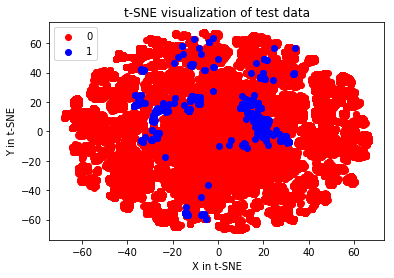

In [73]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()